# TOKENIZE

In [ ]:
import torch 
import numpy as np
from transformers import BartTokenizer, BartForConditionalGeneration
torch.manual_seed(42) 
np.random.seed(42) 

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

In [ ]:
max_length = 1024

# start tokenizing
article_input_ids = tokenizer.batch_encode_plus(train['text'], return_tensors='pt', max_length=max_length, pad_to_max_length=True,truncation=True)['input_ids']
attention_mask_ids = tokenizer.batch_encode_plus(train['text'], return_tensors='pt', max_length=max_length, pad_to_max_length=True,truncation=True)['attention_mask']
labels_id = tokenizer.batch_encode_plus(train['summary'], return_tensors='pt', max_length=max_length, pad_to_max_length=True,truncation=True)['input_ids']

# concatenate all ids column-wise for future use
id = torch.cat((article_input_ids, labels_id, attention_mask_ids), 1)


# TRAINING

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [ ]:
#hyperparameters
lr=1e-05
eps=1e-08
batch_size= 2
epochs= 5
dataset= id

tokenizer = tokenizer

# load pre-trained bart-base model 
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
def training(dataset, lr, eps, batch_size, epochs, model, tokenizer, device):
  """ Train BART model and print out training details."""
  
  model.train()

  train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  optimizer =  torch.optim.Adam(model.parameters(),lr=lr,eps=eps) 
  loss_list = []

  for epoch in range(epochs):
    sum_loss = 0
    i = 0
    for _, id in enumerate(train_dataloader):
      input_ids, labels_id, attention_ids = id[:,:max_length], id[:,max_length:2*max_length], id[:,2*max_length:3*max_length]
      input_ids = input_ids.to(device)
      labels_id = labels_id.to(device)
      attention_ids = attention_ids.to(device)

      # decoder input is target shifted 1 token to the right 
      decoder_input_ids = shift_tokens_right(labels_id, model.config.pad_token_id)
      labels_id[labels_id[:, :] == model.config.pad_token_id] = -100

      optimizer.zero_grad()
      outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, labels=labels_id, attention_mask=attention_ids)

      loss = outputs.loss
      sum_loss += loss
      loss.backward()
      optimizer.step()

    print("epoch: {}/{} --> training loss: {}".format(epoch+1, epochs, sum_loss/dataset.shape[0])) 
    loss_list.append(sum_loss/dataset.shape[0])

  return loss_list

In [ ]:
loss = training(dataset, lr, eps, batch_size, epochs, model, tokenizer, device)

epoch: 1/5 --> training loss: 1.587222933769226
epoch: 2/5 --> training loss: 1.4376198053359985
epoch: 3/5 --> training loss: 1.3622431755065918
epoch: 4/5 --> training loss: 1.3068127632141113
epoch: 5/5 --> training loss: 1.2582640647888184


In [ ]:
# save the model
model.save_pretrained('/..')

In [ ]:
# draw all losses of model with different epochs in the same graph
def training_loss(loss_list, epochs):
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Training Loss--BART')
  plt.plot(range(1, epochs+1), loss_list, marker='o')
  plt.show


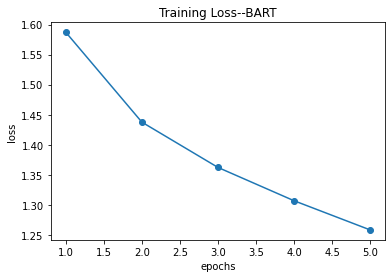

In [ ]:
training_loss(loss, epochs=epochs)

# GENERATE

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [ ]:
# import trained model when needed
# model = BartForConditionalGeneration.from_pretrained('/..')
# model= model.to(device)
# model.resize_token_embeddings(len(tokenizer))

In [ ]:
def truncate_sen(text):
  """ Trim the generated summaries by the last comma',' or dot'.' to form a complete sentence """

  text_split = list(text)
  text_split.reverse()

  # get the index of the last comma and dot, trim by the larger one
  if ',' in text_split and '.' in text_split:
    idx_comma = text_split.index(',')
    idx_dot = text_split.index('.')
    if idx_comma > idx_dot:
      text_split.reverse()
      idx1 = len(text_split) - idx_dot -1       
    else:
      text_split.reverse()
      idx1 = len(text_split) - idx_comma -1     

    new_text_split = text_split[:idx1+1]
    new_sen = ''.join(new_text_split)  
    return new_sen     
  
  # trim by last comma
  elif ',' in text_split:
    idx_comma = text_split.index(',')
    text_split.reverse()
    idx1 = len(text_split) - idx_comma -1 

    new_text_split = text_split[:idx1+1]
    new_sen = ''.join(new_text_split)
    return new_sen

  # trim by last dot
  elif '.' in text_split:
    idx_dot = text_split.index('.')
    text_split.reverse()
    idx1 = len(text_split) - idx_dot -1    

    new_text_split = text_split[:idx1+1]
    new_sen = ''.join(new_text_split)
    return new_sen

  # no trim
  else:
    return text


In [ ]:
test_text = test['text']
test_summary = test['summary'] 

In [ ]:
#generate

model.eval()

with open('gen_summary_bart.csv', 'w', newline='') as csvfile:
    fieldnames = ['gensummary']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    # loop over all test samples, generate summaries and write them into rows in csv file
    for i in range(len(test_text)):
      text_input_ids = tokenizer.batch_encode_plus([test_text.iloc[i]],return_tensors='pt', max_length=max_length, padding=True, truncation=True)['input_ids'].to(device)
      mask_ids = tokenizer.batch_encode_plus([test_text.iloc[i]],return_tensors='pt', max_length=max_length, padding=True, truncation=True)['attention_mask'].to(device)
      summary_ids = model.generate(input_ids = text_input_ids,
                                   attention_mask = mask_ids,
                                   num_beams=3,
                                   max_length=200,
                                   min_length=100)
      summary_txt = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)
      # check if trim is needed
      summary_txt = truncate_sen(summary_txt)

      writer.writerow({'gensummary':summary_txt})  
